In [9]:
dataset = None

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [ ]:
feature_1 = "bmi"

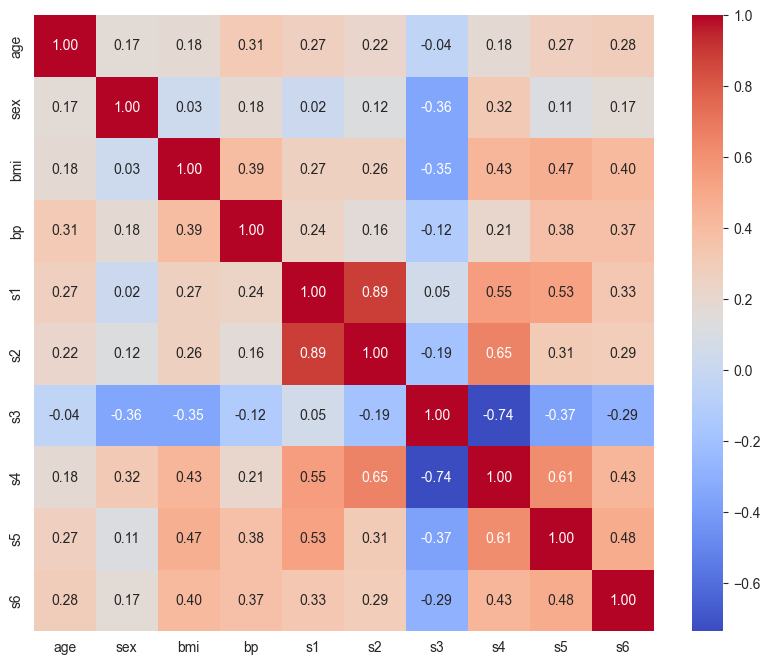

,metadata,age,sex,bp,s1,s2,s3,s4,s5,s6
0,Correlations,0.184695,0.033934,0.394309,0.266467,0.26156,-0.354655,0.430974,0.468473,0.404928


In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from Dashboard.data_preprocessing import load_and_preprocess_data


X_train, X_test, y_train, y_test, task = load_and_preprocess_data()


# Assuming 'category_column' is your categorical column
label_encoder = LabelEncoder()
X_train['sex'] = label_encoder.fit_transform(X_train['sex'])

# Then calculate the correlation matrix
correlation_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()



## Experiment 1

MSE Train: 0.47059960764395203, MSE Test: 0.4547642929721244


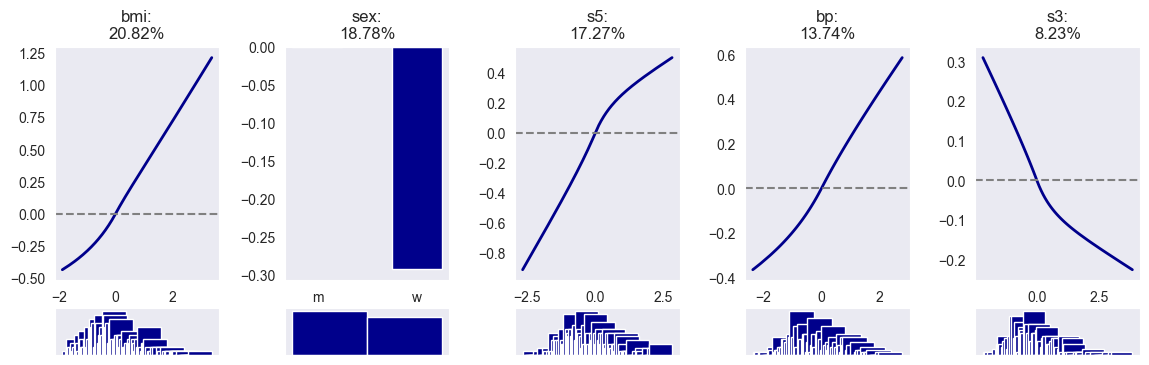

In [53]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, f1_score
from Dashboard.data_preprocessing import load_and_preprocess_data
from Dashboard.model_adapter import ModelAdapter
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, f1_score

X_train, X_test, y_train, y_test, task = load_and_preprocess_data()
adapter = ModelAdapter(task)
adapter.fit(X_train, y_train)
y_train_pred = adapter.predict(X_train)
y_test_pred = adapter.predict(X_test)
if task == "regression":
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    print(f"MSE Train: {mse_train}, MSE Test: {mse_test}")
else:
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    f1_test = f1_score(y_test, y_test_pred, average='weighted')
    print(f"Train F1 Score: {f1_train}, Test F1 Score: {f1_test}")

adapter.model.plot_single(show_n=5)



In [ ]:
# Assumption: BMI has an effect on BP
# Step 1: Get predictions for feature_1 (BMI)

feature_1 = "bmi"
shape_functions_dict = adapter.model.get_shape_functions_as_dict()

i = adapter.model.feature_names.index(feature_1)
feat_values = np.array(X_train[feature_1])
#adapter.model._get_pred_feature_1_of_i(i, np.array(X_train))
#y = torch.tensor(updated_data[feature]['y'], dtype=torch.float64)
if adapter.model.task == "classification":
    pred_feature_1 = adapter.model.init_classifier.coef_[0, i] * feat_values
else:
    pred_feature_1 = adapter.model.init_classifier.coef_[i] * feat_values

if isinstance(pred_feature_1, np.ndarray):
    pred_feature_1 = torch.from_numpy(pred_feature_1).float()

for regressor, boost_rate in zip(adapter.model.regressors, adapter.model.boosting_rates):
    pred_feature_1 += (
        boost_rate
        * regressor.predict_single(torch.tensor(feat_values.reshape(-1, 1), dtype=torch.float), i).squeeze()
    ).cpu()
print(pred_feature_1)

In [51]:
# Step 2: Adjust overall predictions by subtracting the predictions of feature_1
y_train_adjusted = y_train - np.array(pred_feature_1)
# Prepare new X column
X_train_except_feat_1 = X_train.drop(columns=[feature_1])

MSE Train: 0.4664780078636073


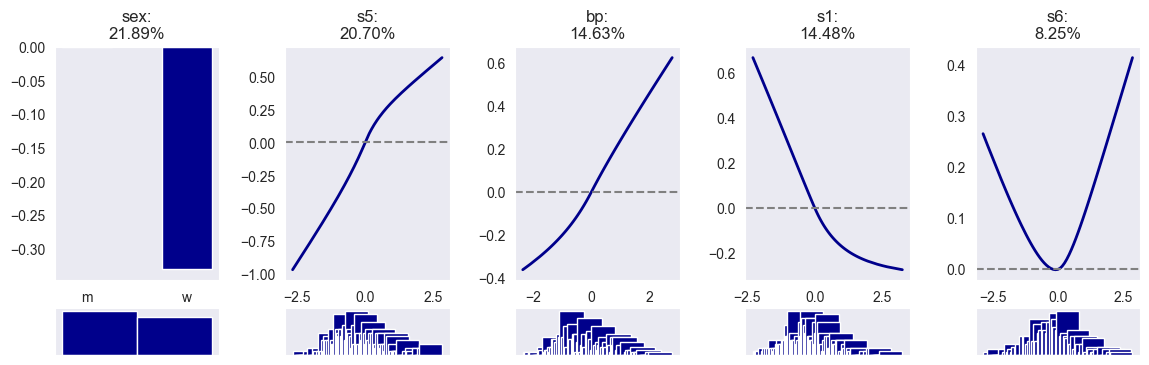

In [59]:
# Step 3:
# Retrain all other features with y_train_adjusted
adapter_adjusted_feat_1 = ModelAdapter(task)
adapter_adjusted_feat_1.fit(X_train_except_feat_1, y_train_adjusted)
y_train_pred_adjusted= adapter_adjusted_feat_1.predict(X_train_except_feat_1)
if task == "regression":
    mse_train_adjusted_feat_1 = mean_squared_error(y_train_adjusted, y_train_pred_adjusted)
    print(f"MSE Train: {mse_train_adjusted_feat_1}")
else:
    f1_train_adjusted_feat_1 = f1_score(y_train_adjusted, y_train_pred_adjusted, average='weighted')
    print(f"Train F1 Score: {f1_train_adjusted_feat_1}")

adapter_adjusted_feat_1.model.plot_single(show_n=5)

In [82]:
# Metrics to quantify the change
if task == "regression":
    main_metric = mse_train - mse_train_adjusted_feat_1
else:
    main_metric = f1_train - f1_train_adjusted_feat_1
print(f"Differenz in MSE or f1: {main_metric}")
shape_functions_dict_adjusted_feat_1 = adapter_adjusted_feat_1.get_shape_functions_as_dict()

correlations_with_feature_1 = correlation_matrix[feature_1]
correlations_with_feature_1 = correlations_with_feature_1.drop(feature_1)
results_columns = ['metadata'] + list(correlations_with_feature_1.index)  # Correlation indices as columns
results_df = pd.DataFrame(columns=results_columns)
results_df.loc[0] = ["Correlations"] + correlations_with_feature_1.tolist()



comparison_results = []

# Iterate through the original dictionary
for original_feature in shape_functions_dict:
    # Skip 'bmi' feature
    if original_feature['name'] == feature_1:
        continue
    
    # Find corresponding feature in the adjusted dictionary
    adjusted_feature = next((item for item in shape_functions_dict_adjusted_feat_1 if item['name'] == original_feature['name']), None)
    
    # Continue if the feature is not found in the adjusted dictionary
    if not adjusted_feature:
        continue
    
    # Calculate average of y values for both features
    avg_y_original = sum(original_feature['y']) / len(original_feature['y'])
    avg_y_adjusted = sum(adjusted_feature['y']) / len(adjusted_feature['y'])
    
    # Calculate the most distant points by finding the maximum absolute difference between corresponding y values
    max_diff = max(abs(o - a) for o, a in zip(original_feature['y'], adjusted_feature['y']))
    
    # Compare avg_effect
    avg_effect_diff = adjusted_feature['avg_effect'] - original_feature['avg_effect']
    
    # Store the comparison results
    comparison_results.append({
        'feature': original_feature['name'],
        'avg_y_original': avg_y_original,
        'avg_y_adjusted': avg_y_adjusted,
        'max_diff_y': max_diff,
        'avg_effect_diff': avg_effect_diff,
    })

new_row = {'metadata': 'Avg Effect Diff'}
for result in comparison_results:
    feature = result['feature']
    avg_effect_diff = result['avg_effect_diff']
    
    new_row[feature] = avg_effect_diff
    # For features not in comparison_results, set to None or another placeholder value
    for col in results_df.columns:
        if col not in new_row:
            new_row[col] = None
new_row_df = pd.DataFrame([new_row])
# Append the new row to the DataFrame
results_df = pd.concat([results_df, new_row_df], ignore_index=True)
results_df

Differenz in MSE or f1: 0.004121599780344709


,metadata,age,sex,bp,s1,s2,s3,s4,s5,s6
0,Correlations,0.184695,0.033934,0.394309,0.266467,0.261560,-0.354655,0.430974,0.468473,0.404928
1,Avg Effect Diff,1.734260,3.115527,0.891152,9.000526,3.151429,-3.535372,1.692856,3.429426,1.342677


C:\Users\jfill\PycharmProjects\Masterthesis\Dashboard\model_adapter.py:144: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat = torch.tensor(y_hat, dtype=torch.float32)


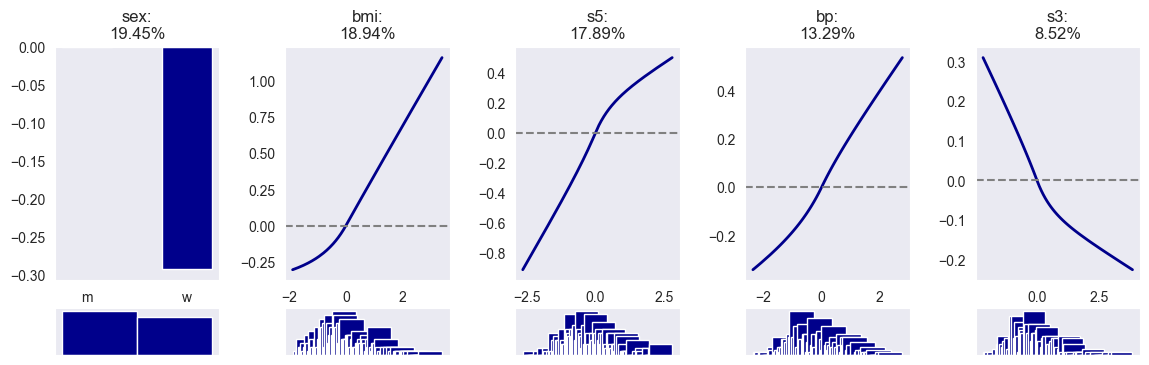

In [73]:
features_to_change = ['bmi', 'bp']
shape_functions_dict = adapter.model.get_shape_functions_as_dict()

# this part is already given in the flask application
feature_current_state = {}
for feature in shape_functions_dict:
    name = feature['name']
    y_value = feature['y']
    feature_current_state[name] = y_value

updated_data = {}

for feature in shape_functions_dict:
    name = feature['name']
    x_values = feature['x']
    if name in features_to_change:
        # Simulate user input (by setting negative values to 0); in flask app just use feature_current_state
        if feature["datatype"] == "categorical":
            #y_values = np.array(feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': np.array([-2]), 'datatype': 'categorical'}
        else:
            y_values = np.where(np.array(feature_current_state[name]) < 0, -0.2, feature_current_state[name])
            updated_data[name] = {'x': x_values, 'y': y_values.tolist(), 'datatype': 'numerical'}
    else:
        if feature['datatype'] == 'numerical':
            updated_data[name] = {'x': x_values, 'y': feature['y'].tolist(), 'datatype': 'numerical'}
        else:
            updated_data[name] = {'x': x_values, 'y': np.array([-0.5]), 'datatype': 'categorical'}
            #y_values = feature_current_state[name]
#spline, retrain_feature
adapter = adapter.adapt(features_to_change, updated_data, "retrain_feature", X_train, y_train)
adapter.plot_single(show_n=5)

### Initival Predictions

In [11]:
y = torch.tensor(updated_data[feature]['y'], dtype=torch.float64)


TypeError: unhashable type: 'dict'